# 変調と復調

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import fftpack as scifft
from scipy import signal as scisp
import soundfile as sf 


# random number
seed = 83988848
rng = np.random.default_rng()


相手のところで聞かせたい$s(t)$は，

In [19]:


duration = 1 # in second

# print(f'{t}')

# 200Hzの純音
Fs_puretone = 44100
t_puretone = np.arange(duration*Fs_puretone)/Fs_puretone
sig_puretone = np.sin(2*np.pi*200*t_puretone + rng.uniform(low=-np.pi,high=+np.pi,size=1))

# 音声
wavfile = "sample/voice_fukusuke.wav"
sig_voice, Fs_voice = sf.read(wavfile)
sig_voice = np.concatenate([sig_voice,sig_voice,sig_voice,sig_voice])
sig_voice = sig_voice[:duration*Fs_voice]

# 200Hz純音か，音声か
sig = sig_voice # sig_puretone
Fs = Fs_voice # Fs_puretone

t = np.arange(duration*Fs)/Fs


信号波 $s(t)$ を 搬送波 $c(t)$ に乗せた 変調波 $m(t)$ を作る

$$ c(t) = A_0 \cos(2\pi f_c t) $$

$$ m(t) = A_s(t) \cos\left(2\pi \left(f_c+F_s(t)\right)t + P_s(t)\right) $$

- AM: $A_s(t) = s(t)$ 
- FM: $F_s(t) = s(t)$ 
- PM: $P_s(t) = s(t)$

In [30]:
carrier_puretone = np.sin(2*np.pi*2000*t + rng.uniform(low=np.pi,high=+np.pi,size=1))
m_AM = 1 

modulated_AM = (m_AM*sig_voice/np.max(np.abs(sig))+1) * carrier_puretone  


m_PM = 2
modulated_PM = np.sin(2*np.pi*2000*t + rng.uniform(low=np.pi,high=+np.pi,size=1) + m_PM*sig)


(0.0, 5000.0)

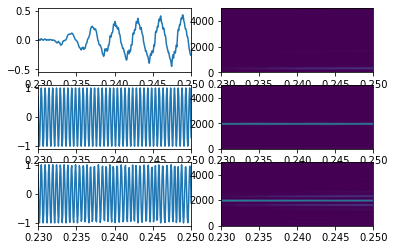

In [31]:

fig = plt.figure()

ax1 = fig.add_subplot(3,2,1)
ax1.plot(t,sig)
ax1.set_xlim([0.23,0.25])

ax2 = fig.add_subplot(3,2,2)
f2, t2, S = scisp.stft(sig, fs=Fs)
ax2.pcolormesh(t2,f2,np.abs(S),vmin=0,vmax=1,shading='gouraud')
ax2.set_xlim([0.23,0.25])
ax2.set_ylim([0,5000])

ax3 = fig.add_subplot(3,2,3)
ax3.plot(t,carrier_puretone)
ax3.set_xlim([0.23,0.25])

ax4 = fig.add_subplot(3,2,4)
f4, t4, C = scisp.stft(carrier_puretone, fs=Fs)
ax4.pcolormesh(t4,f4,np.abs(C),vmin=0,vmax=1,shading='gouraud')
ax4.set_xlim([0.23,0.25])
ax4.set_ylim([0,5000])

ax5 = fig.add_subplot(3,2,5)
ax5.plot(t,modulated_PM)
ax5.set_xlim([0.23,0.25])

ax6 = fig.add_subplot(3,2,6)
f6, t6, M = scisp.stft(modulated_PM, fs=Fs)
ax6.pcolormesh(t6,f6,np.abs(M),vmin=0,vmax=1,shading='gouraud')
ax6.set_xlim([0.23,0.25])
ax6.set_ylim([0,5000])

(0.23, 0.25)

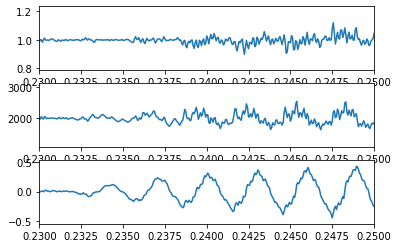

In [35]:
analytic_signal = scisp.hilbert(modulated_PM)
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * Fs)

fig2 = plt.figure()
ax21 = fig2.add_subplot(3,1,1)
ax21.plot(t,amplitude_envelope)
ax21.set_xlim([0.23,0.25])

ax22 = fig2.add_subplot(3,1,2)
ax22.plot(t[1:],instantaneous_frequency)
ax22.set_xlim([0.23,0.25])

ax23 = fig2.add_subplot(3,1,3)
ax23.plot(t,sig)
ax23.set_xlim([0.23,0.25])


$s(t) \in \{0,1\} = b(k)$ のデジタル信号のとき

- ASK: $A_s(t) = Ab(k)$ 
- FSK: $F_s(t) = Fb(k)$
- PSK: $P_s(t) = Pb(k)$
- QSK: $A_s(t) = Ab(2k)$, $P_s(t) = Ab(2k+1)$

## 多重化

複数の変調波を一本化する

- FDM: 周波数$f_c$の異なる変調波を時間同期加算
- TDM: 時間フレームごとに変調波を変更
- CDM/FHSS: FDMだが各信号波が時間フレームごとに$f_c$を変える
- CDM/DSSS: 各信号に別々のPN系列をアダマール積して，時間同期加算